# Imports

In [1]:
from datetime import timedelta
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

from icedef import iceberg, metocean, drift_simulation, plot
from icedef.turnbull import drift

# Iceberg

In [2]:
df = pd.read_csv('csvs/0204980_2015.csv')

In [3]:
df['DataDate_UTC'] = pd.to_datetime(df['DataDate_UTC'])

In [4]:
times = [t.to_pydatetime() for t in df['DataDate_UTC']]

In [5]:
lons = df['Longitude']

In [6]:
lats = df['Latitude']

In [7]:
ref_berg = iceberg.Iceberg('0204980_2015', times[0], lons[0], lats[0], 0, 0, 0, 0, 'LG', 'TAB')

In [8]:
ref_berg.history['T'] = times[:1000]
ref_berg.history['X'] = lons[:1000]
ref_berg.history['Y'] = lats[:1000]

In [9]:
berg = iceberg.clone_iceberg_state(ref_berg)

# Metocean

In [10]:
ocean_data = metocean.ECMWFOcean(ref_berg.history['T'][0], ref_berg.history['T'][-1])

#ocean_data.filenames

In [11]:
atm_data = metocean.NARRAtm(ref_berg.history['T'][0], ref_berg.history['T'][-1])

#atm_data.filenames

# Drift Simulation

In [12]:
sim = drift_simulation.DriftSimulation(berg, ocean_data, atm_data, drift)

In [13]:
dt = 0.1*3600
t0 = ref_berg.history['T'][0]
tf = ref_berg.history['T'][-1]
tdelta = tf - t0
tdelta_secs = tdelta.days*12*3600 + tdelta.seconds
nt = int(tdelta_secs//dt)

In [14]:
#sim.euler(dt,nt)
sim.rk2(dt, nt)

In [15]:
sim.history.head()

,t,vax,vay,vcx,vcy,vx,vy,x,y
0,2015-04-24 15:16:06,-3.217008,-0.978001,0.043383,0.073384,0.000000,0.000000,-51.551440,51.459910
1,2015-04-24 15:22:06,-3.243216,-0.949190,0.043929,0.072737,-0.002218,0.003565,-51.551452,51.459922
2,2015-04-24 15:28:06,-3.269427,-0.920377,0.044472,0.072088,-0.004213,0.006780,-51.551473,51.459943
3,2015-04-24 15:34:06,-3.295639,-0.891564,0.044688,0.071257,-0.006009,0.009689,-51.551505,51.459975
4,2015-04-24 15:40:06,-3.321854,-0.862750,0.044751,0.070342,-0.007651,0.012316,-51.551544,51.460015


# Plot

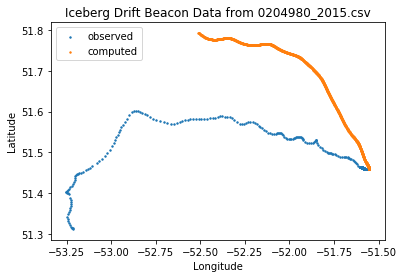

In [16]:
plt.scatter(ref_berg.history['X'], ref_berg.history['Y'], s=2, label='observed')
plt.scatter(sim.history['x'], sim.history['y'], s=2, label='computed')
plt.title('Iceberg Drift Beacon Data from 0204980_2015.csv')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

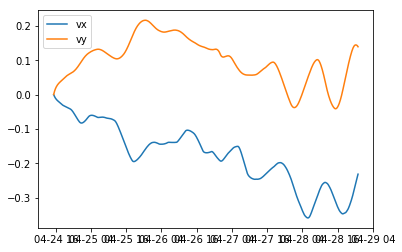

In [17]:
plt.plot(sim.history['t'], sim.history['vx'], label='vx')
plt.plot(sim.history['t'], sim.history['vy'], label='vy')
plt.legend()
plt.show()

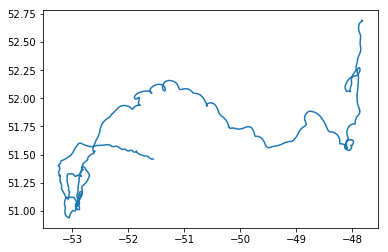

In [18]:
plt.plot(df['Longitude'], df['Latitude'])
plt.show()

In [19]:
from mpl_toolkits.basemap import Basemap
from matplotlib.animation import FuncAnimation

from scipy.interpolate import RegularGridInterpolator as RGI

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [169]:
def berg_metocean_animation(xyt_berg, xyt_grid, grid_scales, uv_data, 
                             fname='field_anim', v_auto = True, vmin=0, vmax=1, 
                             scale=1, headwidth=5, width=5e-3, speed=100):
    
    x_berg, y_berg, t_berg = xyt_berg
    x_grid, y_grid, t_grid = xyt_grid
    x_scale, y_scale, t_scale = grid_scales
    u_data, v_data = uv_data
    
    dx = np.mean(np.diff(x_grid))
    dy = np.mean(np.diff(y_grid))
    dt = np.mean(np.diff(t_grid))
    
    x0 = min(x_berg) - dx
    xf = max(x_berg) + dx
    y0 = min(y_berg) - dy
    yf = max(y_berg) + dy
    t0 = min(t_berg) - dt
    tf = max(t_berg) + dt
    
    xid0 = np.where(abs(x_grid - x0) < dx)[0][0]
    xidf = np.where(abs(x_grid - xf) < dx)[0][-1]
    yid0 = np.where(abs(y_grid - y0) < dy)[0][0]
    yidf = np.where(abs(y_grid - yf) < dy)[0][-1]
    tid0 = np.where(abs(t_grid - t0) < dt)[0][0]
    tidf = np.where(abs(t_grid - tf) < dt)[0][-1]
    
    # overwrite existing variables with a subset of them
    x_grid = x_grid[xid0:xidf+1]
    y_grid = y_grid[yid0:yidf+1]
    t_grid = t_grid[tid0:tidf]
    u_data = u_data[tid0:tidf, yid0:yidf+1, xid0:xidf+1]
    v_data = v_data[tid0:tidf, yid0:yidf+1, xid0:xidf+1]
    
    # make interpolators for u and v data
    u_RGI = RGI((t_grid, y_grid, x_grid), u_data) 
    v_RGI = RGI((t_grid, y_grid, x_grid), v_data)   
    
    # overwrite again with scales 
    x_grid = np.arange(x_grid[0], x_grid[-1], dx/dx_scale)
    y_grid = np.arange(y_grid[0], y_grid[-1], dy/dy_scale)
    t_grid = np.arange(t_grid[0], t_grid[-1], dt/dt_scale)
    
    # initialize matrices
    u_mat = np.empty([len(t_grid), len(y_grid), len(x_grid)])
    v_mat = np.empty([len(t_grid), len(y_grid), len(x_grid)])
    
    # fill matrices with interpolated values
    for i, ival in enumerate(t_grid):
        for j, jval in enumerate(y_grid):
            for k, kval in enumerate(x_grid):
                u_mat[i][j][k] = u_RGI([ival,jval,kval])
                v_mat[i][j][k] = v_RGI([ival,jval,kval])
    
    # make matrix of magnitudes of u and v
    w_mat = np.sqrt(u_mat**2 + v_mat**2)

    # set colorbar bounds
    if v_auto:
        vmin = w_mat.min()
        vmax = w_mat.max()
    
    # setup figure, background, axes, and gridlines
    fig = plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([x0, xf, y0, yf], ccrs.PlateCarree())
    ax.text(-0.2, 0.5, 'latitude', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes)
    ax.text(0.5, -0.2, 'longitude', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes)
    ax.stock_img()
    ax.coastlines('50m')
    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=2,color='gray',alpha=0.5,linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # plot
    im = plt.imshow(w_mat[0,:,:], extent=[x0, xf, y0, yf], origin = 'lower', vmin=vmin, vmax=vmax)
    line, = plt.plot(x_berg[0], y_berg[0], color='black')
    plt.colorbar()  # colorbar must be called before quiv
    quiv = plt.quiver(x_grid, y_grid, u_mat[0,:,:], v_mat[0,:,:], scale=scale, headwidth=headwidth, width=width)
    title = plt.title('time: 0 hours')

    def animate(i):
        im.set_data(w_mat[i,:,:])
        quiv.set_UVC(u_mat[i,:,:], v_mat[i,:,:])
        title.set_text('time: {:.0f} hours'.format(t_grid[i]-t_grid[0]))
        min_indx = np.argmin([abs(t) for t in t_berg - t_grid[i]])
        line.set_data(x_berg[0:min_indx+1], y_berg[0:min_indx+1])
        return im, line
    
    anim = FuncAnimation(fig, animate, frames=w_mat[:,0,0].size-1, interval=speed)
    #HTML(anim.to_html5_video())
    anim.save(f'plots/{fname}.gif',writer='imagemagick')

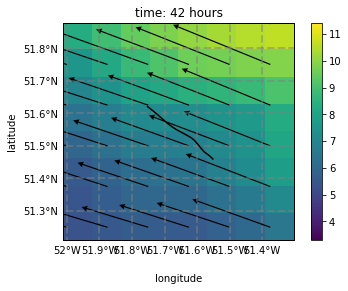

In [170]:
dx_scale = 2
dy_scale = 2
dt_scale = 2
grid_scales = [dx_scale, dy_scale, dt_scale]

x_berg = sim.history['x'][:400]
y_berg = sim.history['y'][:400]
t_berg = nc.date2num(sim.history['t'][:400], atm_data.T_UNITS, atm_data.T_CALENDAR)
xyt_berg = [x_berg, y_berg, t_berg]

x_grid = atm_data.lons
y_grid = atm_data.lats
t_grid = atm_data.times
xyt_grid = [x_grid, y_grid, t_grid]

u_data = atm_data.U
v_data = atm_data.V
uv_data = [u_data, v_data]

berg_metocean_animation(xyt_berg, xyt_grid, grid_scales, uv_data, fname='wind_anim', v_auto=True, scale=20, speed=500)